In [7]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
from skimage.measure import label, regionprops
import skimage
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
import numpy as np
import regex as re
from skimage import morphology
import warnings
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

import math
from Models import DualEncoding_U_Net,load_model
from skimage.morphology import watershed,remove_small_holes,remove_small_objects
from Metrics import get_fast_aji,get_fast_aji_plus,get_fast_pq,get_fast_dice_2,remap_label

# Functions

In [8]:
def whole_dice_metric(y_pred,y_true):
    smooth = 10e-16
    # single image so just roll it out into a 1D array
    
    m1 =np.reshape(y_pred,(-1))/255
    m2 =np.reshape(y_true,(-1))/255
    
    
    intersection = (m1 * m2)

    score = 2. * (np.sum(intersection) + smooth) / (np.sum(m1) +(np.sum(m2) + smooth))
        
    return score

def multiple_erosion(img,iter_count=5,selem=morphology.selem.disk(1)):
    for j in (range(iter_count)):
        img=morphology.binary_erosion(img, selem=selem)
    return img

def multiple_dialte(img,iter_count=5,selem=morphology.selem.disk(1)):
    for j in (range(iter_count)):
        img=morphology.binary_dilation(img, selem=selem)
    return img

def coord2array(coord):
    x=[]
    y=[]
    for i in coord:
        x.append(i[0])
        y.append(i[1])
    return (x,y)
def sort_n_array(img):
    img_labels=label(img)
    img_regions=regionprops(img_labels)
    final_gt=np.zeros_like(img)
    for i,region in enumerate(img_regions):
        coordinates=coord2array(list(region.coords))
        final_gt[coordinates]=i+1
        
    return final_gt

# best post proc for CPM17
def img_recon_CPM17(nuclei,boundary,boundary_length=200,print_prompt=True):
    
    nuclei=nuclei>threshold_otsu(nuclei)
    nuclei=nuclei.astype(np.float32)
    boundary=boundary>50
   
    boundary=boundary.astype(np.float32)
    
    
    nuclei_seeds=nuclei-boundary
    
    nuclei_seeds[np.where(nuclei_seeds<0)]=0
    area=len(np.where(nuclei_seeds==1)[0])
    total_area=nuclei_seeds.shape[0]*nuclei_seeds.shape[1]

    if area/total_area>0.15 and area/total_area<0.30:
        nuclei_seeds=multiple_erosion(nuclei_seeds,2)
        iter_count=2
    elif area/total_area>0.30:
        nuclei_seeds=multiple_erosion(nuclei_seeds,3)
        iter_count=3
    elif area/total_area>0.06 and area/total_area<0.15:
        nuclei_seeds=multiple_erosion(nuclei_seeds,1)
        iter_count=2
    else:
#         nuclei_seeds=multiple_erosion(nuclei_seeds,1)
        iter_count=2

    # args:
    #nuclei : raw nuclei image.
    #boundary : raw_boundary predicitons.
    #n_array_gt : GT N-array mask
    #boundary_length : hyperparameter for growing nuclei seeds
    #iter_limt : hyperparameter for growing nuclei seeds
    #print_prompt : wheter or not to show progress bar
    

    labeled_img=label(nuclei_seeds)
    regions=regionprops(labeled_img)

    final_image=np.zeros_like(nuclei_seeds)
    if print_prompt:
        loop=tqdm(regions)
    else:
        loop=regions
    
    for i,region in enumerate(loop):
        
 
        coordinates=coord2array(list(region.coords))
        x_temp=np.zeros_like(nuclei_seeds)
        x_temp[coordinates]=1
    
        boundary_score=0
        iteration=0
        while boundary_score<boundary_length and iteration<iter_count:
            iteration+=1
            x_temp=morphology.binary_dilation(x_temp, selem=morphology.selem.disk(2)).astype(np.uint8)
            boundary_score=len(np.where(x_temp*boundary==1)[0])



        final_image[np.where(x_temp==1)]=i+1
        final_image=final_image.astype(np.float32)

 
        
    return final_image,area

In [53]:
def img_recon_CPM17(nuclei,boundary,boundary_length=200,print_prompt=True):
    
    nuclei=nuclei>threshold_otsu(nuclei)
    nuclei=nuclei.astype(np.float32)
    boundary=boundary>50
   
    boundary=boundary.astype(np.float32)
    
    
    nuclei_seeds=nuclei-boundary
    
    nuclei_seeds[np.where(nuclei_seeds<0)]=0
    area=len(np.where(nuclei_seeds==1)[0])
    total_area=nuclei_seeds.shape[0]*nuclei_seeds.shape[1]

    if area/total_area>0.15 and area/total_area<0.30:
        nuclei_seeds=multiple_erosion(nuclei_seeds,2)
        iter_count=2
    elif area/total_area>0.30:
        nuclei_seeds=multiple_erosion(nuclei_seeds,3)
        iter_count=3
    elif area/total_area>0.06 and area/total_area<0.15:
        nuclei_seeds=multiple_erosion(nuclei_seeds,1)
        iter_count=2
    else:
#         nuclei_seeds=multiple_erosion(nuclei_seeds,1)
        iter_count=2

    # args:
    #nuclei : raw nuclei image.
    #boundary : raw_boundary predicitons.
    #n_array_gt : GT N-array mask
    #boundary_length : hyperparameter for growing nuclei seeds
    #iter_limt : hyperparameter for growing nuclei seeds
    #print_prompt : wheter or not to show progress bar
    

    labeled_img=label(nuclei_seeds)
    regions=regionprops(labeled_img)

    final_image=np.zeros_like(nuclei_seeds)
    if print_prompt:
        loop=tqdm(regions)
    else:
        loop=regions
    
    for i,region in enumerate(loop):
        
 
        coordinates=coord2array(list(region.coords))
        x_temp=np.zeros_like(nuclei_seeds)
        x_temp[coordinates]=1
    
        boundary_score=0
        iteration=0
        while boundary_score<boundary_length and iteration<iter_count:
            iteration+=1
            x_temp=morphology.binary_dilation(x_temp, selem=morphology.selem.disk(2)).astype(np.uint8)
            boundary_score=len(np.where(x_temp*boundary==1)[0])



        final_image[np.where(x_temp==1)]=i+1
        final_image=final_image.astype(np.float32)

 
        
    return final_image,area


def watershed_seg(nuclei,boundary):
    
    nuclei_th=(nuclei>0.25*255).astype(np.float32)
    boundary_th=(boundary>0.25*255).astype(np.float32)
   
    
    nuclei_seeds=nuclei_th-boundary_th
    nuclei_seeds[np.where(nuclei_seeds<0)]=0
    nuclei_seeds=nuclei_seeds.astype(np.uint8)
    nuclei_seeds=remove_small_holes(nuclei_seeds)
    nuclei_seeds=label(nuclei_seeds)
#     nuclei_seeds=remove_small_objects(nuclei_seeds)
    nuclei_distance_map=ndi.distance_transform_edt(nuclei_seeds)
    
    
    local_maxi = peak_local_max(nuclei_distance_map, indices=False, footprint=np.ones((3, 3)),
                                labels=nuclei_th)
    markers = ndi.label(local_maxi)[0]
    seg_image = watershed(-nuclei_distance_map, markers, mask=nuclei_th)
    
    
    return seg_image

# CPM 17 Reconstruction by dialation 

In [54]:
pred_dir='prediction_dual_2_CPM_17'
img_list=[x for x in os.listdir(pred_dir) if 'nuclei' in x and 'proc' not in x and 'GT' not in x]
avg_aji=0
avg=0
dq_avg=0
sq_avg=0
pq_avg=0
for img_name in tqdm(img_list):#['nuclei_gbm_image01.png']:
    
    nuclei=imread(pred_dir+'/'+img_name)
    
    

    boundary=imread((pred_dir+'/'+'bound_'+'_'.join(img_name.split('_')[1:])))
    gt=imread('other_data/CPM_17/Test/NucleiMaps/'+'_'.join(img_name.split('_')[1:]).split('.')[0]+'.png')
  
    img_pred,_=img_recon_CPM17(nuclei,boundary,print_prompt=False)#watershed_seg(nuclei,boundary)#
    img_pred=remap_label(img_pred,True)
    
    dice_img=(img_pred>0).astype(np.uint8)*255
    dice=whole_dice_metric(dice_img,gt)

    f = open('other_data/CPM_17/Test/GT_Mask/'+'_'.join(img_name.split('_')[1:]).split('.')[0]+'_mask.txt', 'r')
    x = f.readlines()

    n_array=np.array([int(a) for a in x[1:]]).reshape(list(map(int, re.findall('\d+', x[0]))))
    n_array=remap_label(n_array,True)
#     plt.imshow(n_array);plt.show()
#     imsave((pred_dir+'/'+img_name.split('.')[0]+'_GT.png',n_array.astype(np.int16))
    img_pred=img_pred.astype(np.int16)
    aji=get_fast_aji(n_array,img_pred)
    pq,_=get_fast_pq(n_array,img_pred)
    dq=pq[0]
    sq=pq[1]
    pq=pq[-1]
    
    
#     imsave((pred_dir+'/'+img_name.split('.')[0]+'_proc.png',img_pred.astype(np.int16))

    avg+=dice
    avg_aji+=aji
    dq_avg+=dq
    sq_avg+=sq
    pq_avg+=pq
    print(img_name.split('.')[0],' : ',dice,aji,dq,sq,pq)
print("DICE : ",avg/len(img_list))
print("AJI : ",avg_aji/len(img_list))
print("DQ : ",dq_avg/len(img_list))
print("SQ : ",sq_avg/len(img_list))
print("PQ : ",pq_avg/len(img_list))


nuclei_gbm_image01  :  0.8014205898912902 0.4985592907277429 0.651685393258427 0.7413393253228889 0.48312000976098385
nuclei_lgg_image02  :  0.877773990212675 0.683384288669608 0.8675496688741722 0.790135522304887 0.6854818107413259
nuclei_lgg_image04  :  0.8461149112785434 0.6405576903910256 0.8152866242038217 0.7473041065702627 0.6092670422993225
nuclei_gbm_image05  :  0.8887641060010506 0.6062453531598513 0.7640449438202247 0.7850769705590114 0.5998340898653121
nuclei_lung_image05  :  0.9223797825184912 0.6757216117216117 0.8300395256916996 0.8302441287140002 0.6891354428060871
nuclei_lung_image08  :  0.88030831666691 0.6660904540781164 0.7915690866510539 0.7943093531182315 0.6287507291661879
nuclei_gbm_image04  :  0.8978515625 0.7540820245596188 0.9204301075268817 0.8098972169155808 0.7454537824513303
nuclei_gbm_image02  :  0.8089264067999591 0.45814888656101105 0.6177606177606177 0.7307193006451349 0.4514096065761451
nuclei_hnsc_image03  :  0.8732022247363037 0.752896068827662 0.8

# BEST CPM 17 dialation 
nuclei_gbm_image01  :  0.8214666279182408 12868<br/>
nuclei_lgg_image02  :  0.871614730878187 64306<br/>
nuclei_lgg_image04  :  0.8228840588270038 41948<br/>
nuclei_gbm_image05  :  0.8945122519332899 16635<br/>
nuclei_lung_image05  :  0.8967014977589723 52581<br/>
nuclei_lung_image08  :  0.8757263674277889 43220<br/>
nuclei_gbm_image04  :  0.8841680624690368 55356<br/>
nuclei_gbm_image02  :  0.7925804468128715 11195<br/>
nuclei_hnsc_image03  :  0.8868635778021663 58493<br/>
nuclei_hnsc_image04  :  0.8471280383960366 54710<br/>
nuclei_gbm_image08  :  0.9125669596006607 41017<br/>
nuclei_lung_image06  :  0.9118775898376469 44832<br/>
nuclei_lgg_image03  :  0.8690029420020168 31731<br/>
nuclei_lgg_image05  :  0.8358029450312235 21205<br/>
nuclei_lgg_image06  :  0.8289500267395568 29558<br/>
nuclei_gbm_image06  :  0.8605572485851111 14334<br/>
nuclei_gbm_image03  :  0.8747670485157347 44686<br/>
nuclei_lung_image02  :  0.8159096441263813 41334<br/>
nuclei_gbm_image07  :  0.8958297068112302 26885<br/>
nuclei_lung_image03  :  0.8657846436219028 34675<br/>
nuclei_hnsc_image01  :  0.8072174361824606 13508<br/>
nuclei_hnsc_image05  :  0.8295879643401209 42940<br/>
nuclei_lung_image07  :  0.9064625496599206 54217<br/>
nuclei_hnsc_image06  :  0.8209365064071683 59521<br/>
nuclei_lgg_image08  :  0.8726363494295983 39956<br/>
nuclei_lung_image01  :  0.7938195935348232 56722<br/>
nuclei_lgg_image01  :  0.7761772950863026 19420<br/>
nuclei_hnsc_image02  :  0.843762329361635 56059<br/>
nuclei_hnsc_image07  :  0.8488544610039589 46205<br/>
nuclei_lgg_image07  :  0.8883423816373563 19562<br/>
nuclei_lung_image04  :  0.8555564148171062 46814<br/>
nuclei_hnsc_image08  :  0.8295273080200204 63858<br/>
0.8542992188929854<br/>


if area>30000 and area<50000:<br/>
         <p>nuclei_seeds=multiple_erosion(nuclei_seeds,2</p>)<br/>
         <p>iter_count=2</p><br/>
elif area>50000:<br/>
   <p> nuclei_seeds=multiple_erosion(nuclei_seeds,3)</p><br/>
    <p>iter_count=3</p><br/>
else:<br/>
    <p>iter_count=2</p><br/>

# prediction of kumar

In [ ]:

img_list=[x for x in os.listdir('prediction_kumar') if 'nuc' in x and 'proc' not in x]
avg=0
for img_name in tqdm(img_list):
    nuclei=imread('prediction_kumar/'+img_name)
    thresh=threshold_otsu(nuclei)
    nuclei=nuclei>thresh
#     nuclei=multiple_erosion(nuclei,iter=3)
    
#     boundary=imread('prediction_kumar/'+'bound_'+'_'.join(img_name.split('_')[1:]))
    
    gt=imread('processed_data/nucleus_maps/'+img_name.split('.')[0].split('_')[1]+'_nucleus_mask.png')
#     img_pred=img_recon(nuclei,boundary,boundary_length=150,iter_limt=2,print_prompt=False)
    img_pred=nuclei
    imsave('prediction_kumar/'+img_name.split('.')[0]+'_proc.png',img_pred.astype(np.float32))
    
    img_pred=img_pred>0
    dice=whole_dice_metric(img_pred.astype(np.float32)*255,gt)
    avg+=dice
    print(img_name.split('.')[0].split('_')[1],' : ',dice,thresh)
print(avg/len(img_list))

TCGA-E2-A14V-01Z-00-DX1  :  0.8225290612209419<br/>
TCGA-21-5786-01Z-00-DX1  :  0.6991805205647318<br/>
TCGA-21-5784-01Z-00-DX1  :  0.7702200475923103<br/>
TCGA-B0-5710-01Z-00-DX1  :  0.7629844577597736<br/>
TCGA-G2-A2EK-01A-02-TSB  :  0.7624224458621036<br/>
TCGA-CH-5767-01Z-00-DX1  :  0.7970872142252329<br/>
TCGA-RD-A8N9-01A-01-TS1  :  0.8176449329279959<br/>
TCGA-G9-6348-01Z-00-DX1  :  0.7966429519738157<br/>
TCGA-DK-A2I6-01A-01-TS1  :  0.8649618223341795<br/>
TCGA-KB-A93J-01A-01-TS1  :  0.8129848869951398<br/>
TCGA-AY-A8YK-01A-01-TS1  :  0.7642849375366202<br/>
TCGA-E2-A1B5-01Z-00-DX1  :  0.7747906286441217<br/>
TCGA-NH-A8F7-01A-01-TS1  :  0.7865019409500186<br/>
TCGA-HE-7128-01Z-00-DX1  :  0.6759419369045772<br/>
0.77915555610654<br/>
# Model 30th Jan 2020 model_optim.pth
TCGA-21-5784-01Z-00-DX1  :  0.8116361668301593 108<br/>
TCGA-RD-A8N9-01A-01-TS1  :  0.8782868692362495 117<br/>
TCGA-CH-5767-01Z-00-DX1  :  0.815197744362616 115<br/>
TCGA-AY-A8YK-01A-01-TS1  :  0.7743249219687112 114<br/>
TCGA-G2-A2EK-01A-02-TSB  :  0.7873815363001121 108<br/>
TCGA-G9-6348-01Z-00-DX1  :  0.8273699189706346 112<br/>
TCGA-KB-A93J-01A-01-TS1  :  0.8798372531910145 118<br/>
TCGA-DK-A2I6-01A-01-TS1  :  0.883796541868124 115<br/>
TCGA-21-5786-01Z-00-DX1  :  0.7315855593758265 111<br/>
TCGA-E2-A14V-01Z-00-DX1  :  0.8599896627535161 113<br/>
TCGA-NH-A8F7-01A-01-TS1  :  0.7949021136999774 113<br/>
TCGA-E2-A1B5-01Z-00-DX1  :  0.802531826634244 110<br/>
TCGA-HE-7128-01Z-00-DX1  :  0.788953461927371 105<br/>
TCGA-B0-5710-01Z-00-DX1  :  0.828047288316124 109<br/>
0.8188457761024771<br/>

# Model 31st 2 channel pred with only otsu
TCGA-G9-6348-01Z-00-DX1  :  0.7819525407623568 108<br/>
TCGA-KB-A93J-01A-01-TS1  :  0.8811115372673644 122<br/>
TCGA-CH-5767-01Z-00-DX1  :  0.8138068067885593 111<br/>
TCGA-DK-A2I6-01A-01-TS1  :  0.8401957024486049 118<br/>
TCGA-NH-A8F7-01A-01-TS1  :  0.7201258488319375 124<br/>
TCGA-B0-5710-01Z-00-DX1  :  0.8268603691132442 107<br/>
TCGA-HE-7128-01Z-00-DX1  :  0.7434148978191721 94<br/>
TCGA-21-5784-01Z-00-DX1  :  0.7782766771403891 108<br/>
TCGA-E2-A1B5-01Z-00-DX1  :  0.7851957232741299 106<br/>
TCGA-RD-A8N9-01A-01-TS1  :  0.8711696861502439 120<br/>
TCGA-21-5786-01Z-00-DX1  :  0.7051864689168885 107<br/>
TCGA-E2-A14V-01Z-00-DX1  :  0.8391341602292577 113<br/>
TCGA-G2-A2EK-01A-02-TSB  :  0.6983577090485372 110<br/>
TCGA-AY-A8YK-01A-01-TS1  :  0.6546214106691893 126<br/>
0.7813863956042768<br/>
# Model 31st 2 channel pred with boundary constratined growing of nuclei seeds
TCGA-G9-6348-01Z-00-DX1  :  0.7193487672267217 108<br/>
TCGA-KB-A93J-01A-01-TS1  :  0.7978143579195152 122<br/>
TCGA-CH-5767-01Z-00-DX1  :  0.7869126701887118 111<br/>
TCGA-DK-A2I6-01A-01-TS1  :  0.8429467108874303 118<br/>
TCGA-NH-A8F7-01A-01-TS1  :  0.7064353205931725 124<br/>
TCGA-B0-5710-01Z-00-DX1  :  0.7426428449341953 107<br/>
TCGA-HE-7128-01Z-00-DX1  :  0.6464007628952234 94<br/>
TCGA-21-5784-01Z-00-DX1  :  0.7619342935549388 108<br/>
TCGA-E2-A1B5-01Z-00-DX1  :  0.751238314651544 106<br/>
TCGA-RD-A8N9-01A-01-TS1  :  0.8106484504188964 120<br/>
TCGA-21-5786-01Z-00-DX1  :  0.5648986336791768 107<br/>
TCGA-E2-A14V-01Z-00-DX1  :  0.815677097344578 113<br/>
TCGA-G2-A2EK-01A-02-TSB  :  0.760678717070453 110<br/>
TCGA-AY-A8YK-01A-01-TS1  :  0.6709322769456747 126<br/>
0.7413220870221593<br/>

# predicition CoNSep

# Best Post PRocess for CoNSep


def img_recon_consep(nuclei,boundary,print_prompt=True):
    

    nuclei=nuclei>0.6*255
    
    nuclei=nuclei.astype(np.float32)
    nuclei=ndimage.binary_fill_holes(nuclei).astype(int)
    
    boundary=boundary>0.5*255#120
    boundary=boundary.astype(np.float32)
        
    nuclei_seeds=nuclei-boundary
    nuclei_seeds[np.where(nuclei_seeds<0)]=0
    nuclei_seeds=ndimage.binary_fill_holes(nuclei_seeds).astype(int)
    
    


    labeled_img=label(nuclei_seeds)
    regions=regionprops(labeled_img)

    final_image=np.zeros_like(nuclei_seeds)
    if print_prompt:
        loop=tqdm(regions)
    else:
        loop=regions
    
    for i,region in enumerate(loop):
        
        coordinates=coord2array(list(region.coords))
        area_region=len(coordinates[0])
        boundary_length=[math.sqrt(area_region/math.pi)*math.pi*2 if math.sqrt(area_region/math.pi)*math.pi*2>50 else 50][-1]
        x_temp=np.zeros_like(nuclei_seeds)
        x_temp[coordinates]=1

        x_temp=morphology.binary_dilation(x_temp, selem=morphology.selem.disk(2)).astype(np.uint8)
           



        final_image[np.where(x_temp==1)]=i+1
        final_image=final_image.astype(np.float32)

 
        
    return final_image


def watershed_seg_consep(nuclei,boundary):
    
    nuclei_th=(nuclei>0.25*255).astype(np.float32)
    boundary_th=(boundary>0.25*255).astype(np.float32)
   
    
    nuclei_seeds=nuclei_th-boundary_th
    nuclei_seeds[np.where(nuclei_seeds<0)]=0
    nuclei_seeds=nuclei_seeds.astype(np.uint8)
    nuclei_seeds=remove_small_holes(nuclei_seeds)
    nuclei_seeds=label(nuclei_seeds)
#     nuclei_seeds=remove_small_objects(nuclei_seeds)
    nuclei_distance_map=ndi.distance_transform_edt(nuclei_seeds)
    
    
    local_maxi = peak_local_max(nuclei_distance_map, indices=False, footprint=np.ones((3, 3)),
                                labels=nuclei_th)
    markers = ndi.label(local_maxi)[0]
    seg_image = watershed(-nuclei_distance_map, markers, mask=nuclei_th)
    
    
    return seg_image

In [41]:
# def sort_n_array(img):
#     img_labels=label(img)
#     img_regions=regionprops(img_labels)
#     final_gt=np.zeros_like(img,dtype=np.int16)
#     for i,region in enumerate(img_regions):
#         coordinates=coord2array(list(region.coords))
#         final_gt[coordinates]=i+1
        
#     return final_gt


def img_recon_consep(nuclei,boundary,print_prompt=True):
    
    # args:
    #nuclei : raw nuclei image.
    #boundary : raw_boundary predicitons.
    #print_prompt : wheter or not to show progress bar

    nuclei=nuclei>0.6*255#threshold_otsu(nuclei)
    
    nuclei=nuclei.astype(np.float32)
    nuclei=ndimage.binary_fill_holes(nuclei).astype(int)
    
    boundary=boundary>0.5*255#120
    boundary=boundary.astype(np.float32)
    
    
    nuclei_seeds=nuclei-boundary
    nuclei_seeds[np.where(nuclei_seeds<0)]=0
    
    nuclei_seeds=ndimage.binary_fill_holes(nuclei_seeds).astype(int)
    area=len(np.where(nuclei_seeds==1)[0])
    total_area=nuclei_seeds.shape[0]*nuclei_seeds.shape[1]
    
    

    nuclei_seeds=morphology.binary_erosion(nuclei_seeds, selem=morphology.selem.disk(1)).astype(np.uint8)


    labeled_img=label(nuclei_seeds)
    regions=regionprops(labeled_img)

    final_image=np.zeros_like(nuclei_seeds)
    if print_prompt:
        loop=tqdm(regions)
    else:
        loop=regions
    
    for i,region in enumerate(loop):
        
 
        coordinates=coord2array(list(region.coords))
        area_region=len(coordinates[0])

        x_temp=np.zeros_like(nuclei_seeds)
        x_temp[coordinates]=1

        x_temp=morphology.binary_dilation(x_temp, selem=morphology.selem.disk(2)).astype(np.uint8)

        final_image[np.where(x_temp==1)]=i+1
        final_image=final_image.astype(np.float32)

 
        
    return final_image,area/total_area


def watershed_seg_consep(nuclei,boundary):
    
    nuclei_th=(nuclei>0.25*255).astype(np.float32)
    boundary_th=(boundary>0.25*255).astype(np.float32)
   
    
    nuclei_seeds=nuclei_th-boundary_th
    nuclei_seeds[np.where(nuclei_seeds<0)]=0
    nuclei_seeds=nuclei_seeds.astype(np.uint8)
    nuclei_seeds=remove_small_holes(nuclei_seeds)
    nuclei_seeds=label(nuclei_seeds)
#     nuclei_seeds=remove_small_objects(nuclei_seeds)
    nuclei_distance_map=ndi.distance_transform_edt(nuclei_seeds)
    
    
    local_maxi = peak_local_max(nuclei_distance_map, indices=False, footprint=np.ones((3, 3)),
                                labels=nuclei_th)
    markers = ndi.label(local_maxi)[0]
    seg_image = watershed(-nuclei_distance_map, markers, mask=nuclei_th)
    
    
    return seg_image

In [82]:
import pandas as pd
df = pd.DataFrame(columns=['Image', 'Area_ratio', 'Dice','AJI','DQ','SQ','PQ'])
pred_dir_CoNSep='prediction_dual_2_CoNSep'
img_list=[x for x in os.listdir(pred_dir_CoNSep) if 'test' and 'nuc' in x and 'proc' not in x]
avg=0
avg_aji=0
dq_avg=0
sq_avg=0
pq_avg=0
for img_name in tqdm(img_list):
    boundary=imread(pred_dir_CoNSep+'/'+'bound_'+'_'.join(img_name.split('_')[1:]))
    nuclei=imread(pred_dir_CoNSep+'/'+img_name)
    gt=np.load('other_data/CoNSeP/Test/Labels/'+'_'.join(img_name.split('_')[1:]).split('.')[0]+'.npy')[:,:,0]
    gt=remap_label(gt)
    
    imsave(pred_dir_CoNSep+'/'+'GT'+'_'.join(img_name.split('_')[1:]),gt.astype(np.int16))
    gt_dice=(gt>0).astype(np.uint8)*255
    
    img_pred,area=img_recon_consep(nuclei,boundary,print_prompt=False)
    img_pred=remap_label(img_pred)
    pred_dice=(img_pred>0).astype(np.uint8)*255

    imsave(pred_dir_CoNSep+'/'+img_name.split('.')[0]+'_proc.png',img_pred.astype(np.int16))

    dice=whole_dice_metric(pred_dice,gt_dice)
    aji=get_fast_aji(gt,img_pred)
    pq,_=get_fast_pq(gt,img_pred)
    dq=pq[0]
    sq=pq[1]
    pq=pq[-1]
    df = df.append({'Image': img_name.split('.')[0],'Area_ratio':area ,'Dice': dice,\
                    'AJI': aji,'DQ':dq,'SQ':sq,'PQ':pq}, ignore_index=True)
    
    avg+=dice
    avg_aji+=aji
    dq_avg+=dq
    sq_avg+=sq
    pq_avg+=pq
    print(img_name.split('.')[0],' : ',area,dice,aji,dq,sq,pq)
print("DICE : ",avg/len(img_list))
print("AJI : ",avg_aji/len(img_list))
print("DQ : ",dq_avg/len(img_list))
print("SQ : ",sq_avg/len(img_list))
print("PQ : ",pq_avg/len(img_list))
df.to_csv('metric_comp.csv',index=False)


Lossy conversion from int16 to uint8. Range [0, 1077]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 703]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_11  :  0.208781 0.83553634118575 0.3298490761715019 0.45280898876404496 0.7318010544571555 0.3313660954452064


Lossy conversion from int16 to uint8. Range [0, 394]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 465]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_3  :  0.1779 0.8483916825945299 0.5061102288703334 0.5681024447031432 0.764370510623889 0.4342407557444213


Lossy conversion from int16 to uint8. Range [0, 910]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 938]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_5  :  0.199673 0.7939560386538695 0.48192588685732146 0.6168831168831169 0.7748405464628675 0.4779860513894313


Lossy conversion from int16 to uint8. Range [0, 418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 506]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_4  :  0.222388 0.8479256196934623 0.49612557077098257 0.551948051948052 0.7614158418777031 0.42026199064678416


Lossy conversion from int16 to uint8. Range [0, 556]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 737]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_14  :  0.232329 0.8073309982988776 0.5253428001845173 0.6666666666666666 0.7965903819130826 0.5310602546087217


Lossy conversion from int16 to uint8. Range [0, 865]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 861]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_1  :  0.162261 0.8380418394724546 0.4207979421090835 0.6129779837775203 0.7507037901917436 0.46016489572587765


Lossy conversion from int16 to uint8. Range [0, 845]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 1084]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_10  :  0.171335 0.806823390892993 0.5257462057881981 0.6314152410575428 0.7703555364149355 0.48641422672544915


Lossy conversion from int16 to uint8. Range [0, 245]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 396]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_2  :  0.077628 0.7316012084592145 0.5158778260134183 0.49297971918876754 0.7453072303809374 0.3674213491425526


Lossy conversion from int16 to uint8. Range [0, 300]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 325]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_6  :  0.092986 0.8473003413761873 0.5977352404057639 0.6976 0.7923352316397236 0.5527330575918712


Lossy conversion from int16 to uint8. Range [0, 513]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 463]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_9  :  0.087774 0.8164808213686892 0.5245270938173976 0.6577868852459017 0.7837151350880205 0.51551753762962


Lossy conversion from int16 to uint8. Range [0, 626]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 544]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_8  :  0.219496 0.8388882670010948 0.2699766075913656 0.4598290598290598 0.7474293554103689 0.34368973778699013


Lossy conversion from int16 to uint8. Range [0, 1359]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 1084]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_13  :  0.211809 0.8343349917081261 0.48804215102626836 0.6230045026606631 0.7802546886920292 0.4861021842772282


Lossy conversion from int16 to uint8. Range [0, 428]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 491]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_12  :  0.120065 0.8327586084813811 0.6264664223080001 0.720348204570185 0.773041764665906 0.5568592472348529


Lossy conversion from int16 to uint8. Range [0, 241]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [0, 186]. Convert image to uint8 prior to saving to suppress this warning.


nuclei_test_7  :  0.039976 0.8103772077039878 0.46324392824340505 0.5386416861826698 0.7326570897812564 0.3946396502334637
DICE :  0.8206962397779013
AJI :  0.48369764143982547
DQ :  0.5922137536769523
SQ :  0.7646298683999728
PQ :  0.454175502441605


# model 4th feb, predicts only nuclei (CPM-17)

nuclei_gbm_image01  :  0.7277193766051461 108<br/>
nuclei_lgg_image02  :  0.8795810296965031 120<br/>
nuclei_lgg_image04  :  0.8498570690545892 120<br/>
nuclei_gbm_image05  :  0.8793331994376381 115<br/>
nuclei_lung_image05  :  0.9245344129554656 119<br/>
nuclei_lung_image08  :  0.8866071888262075 118<br/>
nuclei_gbm_image04  :  0.901806647358985 119<br/>
nuclei_gbm_image02  :  0.7480424652927895 110<br/>
nuclei_hnsc_image03  :  0.8753627522274856 123<br/>
nuclei_hnsc_image04  :  0.8324088699506544 121<br/>
nuclei_gbm_image08  :  0.8804250959880733 123<br/>
nuclei_lung_image06  :  0.9121998339236388 119<br/>
nuclei_lgg_image03  :  0.8737407376571477 117<br/>
nuclei_lgg_image05  :  0.8594481376923777 111<br/>
nuclei_lgg_image06  :  0.8453096210846751 113<br/>
nuclei_gbm_image06  :  0.8566324907627181 115<br/>
nuclei_gbm_image03  :  0.8456073644186511 118<br/>
nuclei_lung_image02  :  0.7613867304243873 117<br/>
nuclei_gbm_image07  :  0.8679014858538571 119<br/>
nuclei_lung_image03  :  0.8728274257561243 117<br/>
nuclei_hnsc_image01  :  0.8321472120607472 111<br/>
nuclei_hnsc_image05  :  0.8198542347323448 118<br/>
nuclei_lung_image07  :  0.9227191260561577 120<br/>
nuclei_hnsc_image06  :  0.8079416106090396 116<br/>
nuclei_lgg_image08  :  0.8623812006255764 121<br/>
nuclei_lung_image01  :  0.7257110540330373 112<br/>
nuclei_lgg_image01  :  0.8665360156781187 117<br/>
nuclei_hnsc_image02  :  0.8480114118805828 120<br/>
nuclei_hnsc_image07  :  0.841697827604559 119<br/>
nuclei_lgg_image07  :  0.8837092227144583 115<br/>
nuclei_lung_image04  :  0.8561029083091506 119<br/>
nuclei_hnsc_image08  :  0.8350518485518164 119<br/>
0.8494561127444595<br/>

# junk

In [ ]:
nuclei=imread('prediction_CPM_17/nuclei_lung_image02.png')
boundary=imread('prediction_CPM_17/bound_lung_image02.png')
gt=imread('other_data/CPM_17/Test/NucleiMaps/lung_image02.png')
gt_bound=imread('other_data/CPM_17/Test/BoundaryMaps/lung_image01.png')
# boundary=(boundary>60).astype(np.float32)

# # seg_image=watershed_seg(nuclei,boundary)

# nuclei=(nuclei>155).astype(np.float32)#threshold_otsu(nuclei)
# nuclei=ndimage.binary_fill_holes(nuclei).astype(int)

# # boundary=multiple_dialte(boundary,iter_count=2,selem=morphology.selem.square(5))
# # boundary=multiple_erosion(boundary,iter_count=1,selem=morphology.selem.square(5))

plt.figure(1,figsize=(10,10))
plt.imshow(nuclei)
plt.figure(2,figsize=(10,10))
plt.imshow(boundary)
plt.figure(3,figsize=(10,10))
plt.imshow(gt)
plt.figure(4,figsize=(10,10))
plt.imshow(gt_bound)

f = open('other_data/CPM_17/Test/GT_Mask/lung_image02_mask.txt','r')
x = f.readlines()
n_array_gt=np.array([int(a) for a in x[1:]]).reshape(list(map(int, re.findall('\d+', x[0]))))
n_array_gt=sort_n_array(n_array_gt)
labeled_gt=label(n_array_gt)
gt_regions=regionprops(labeled_gt)
plt.figure(5,figsize=(10,10))
plt.imshow(n_array_gt)
print("Number of regions",len(gt_regions))

In [ ]:

# print(np.amax(boundary_th))




plt.figure(7,figsize=(10,10))
plt.imshow(nuclei_seeds)


plt.figure(8,figsize=(10,10))
plt.imshow(nuclei_seeds)
labeled_seeds=label(nuclei_seeds)
seeds_regions=regionprops(labeled_seeds)
print(len(seeds_regions))


In [ ]:
nuclei_distance_map=ndi.distance_transform_edt(nuclei_seeds)
plt.figure(9,figsize=(10,10))
plt.imshow(1-nuclei_distance_map)

In [ ]:
local_maxi = peak_local_max(nuclei_distance_map, indices=False, footprint=np.ones((3, 3)),
                            labels=nuclei_th)
markers = ndi.label(local_maxi)[0]
labels = watershed(-nuclei_distance_map, markers, mask=nuclei_th)
plt.figure(10,figsize=(10,10))
plt.imshow(labels)

In [ ]:
get_fast_aji(sort_n_array(n_array_gt),sort_n_array(labels))

In [ ]:
nuclei_seeds=nuclei-boundary
nuclei_seeds[nuclei_seeds<0]=0
# nuclei_seeds=multiple_erosion(nuclei_seeds,4,selem=morphology.selem.square(3))

labeled_img=label(nuclei_seeds)
regions=regionprops(labeled_img)
print(len(regions))

# nuclei_seeds=ndimage.binary_fill_holes(nuclei_seeds).astype(int)
plt.imshow(nuclei_seeds)


In [ ]:

final_image=np.zeros_like(nuclei_seeds)
loop=tqdm(regions)
for i,region in enumerate(loop):


    coordinates=coord2array(list(region.coords))
    x_temp=np.zeros_like(nuclei_seeds)
    x_temp[coordinates]=1
    x_temp=skimage.morphology.reconstruction(x_temp, nuclei, method='dilation', selem=None, offset=None)



    final_image[np.where(x_temp==1)]=i+1
    final_image=final_image.astype(np.int16)
plt.figure(figsize=(10,10))   
plt.imshow(final_image)

In [ ]:
get_fast_aji(sort_n_array(n_array_gt),sort_n_array(final_image))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
nuclei_2=(nuclei>threshold_otsu(nuclei)).astype(np.float32)#threshold_otsu(nuclei)
boundary=(boundary>threshold_otsu(boundary)).astype(np.float32)
nuclei_seeds=nuclei_2-boundary
nuclei_seeds[nuclei_seeds<0]=0
nuclei_seeds=morphology.binary_opening(nuclei_seeds)#multiple_erosion(nuclei_seeds,2,selem=morphology.selem.square(3))
nuclei_seeds=ndimage.binary_fill_holes(nuclei_seeds).astype(int)
nuclei_seeds=ndi.label(nuclei_seeds)[0]

plt.imshow(nuclei_seeds)

In [ ]:
th=watershed(255-nuclei, nuclei_seeds, mask=ndimage.binary_fill_holes(nuclei_2).astype(int))

plt.imshow(th)

In [ ]:
get_fast_aji(sort_n_array(n_array_gt),sort_n_array(th))

In [ ]:
plt.imshow(ndi.distance_transform_edt(n_array_gt))

In [ ]:
labeled_img=label(n_array_gt)
regions=regionprops(labeled_img)
print(len(regions))
final_image=np.zeros_like(n_array_gt)
temp=np.zeros_like(n_array_gt)
# loop=tqdm(regions)
coordinates=coord2array(list(regions[23].coords))
final_image[coordinates]=1


# for i,region in enumerate(loop):


#     coordinates=coord2array(list(region.coords))
#     x_temp=np.zeros_like(nuclei_seeds)
#     x_temp[coordinates]=1
#     x_temp=ndi.distance_transform_edt(x_temp)
    



#     final_image[np.where(x_temp==1)]=i+1
#     final_image=final_image.astype(np.int16)
plt.figure(figsize=(10,10))   
plt.imshow(1-ndi.distance_transform_edt(final_image))

In [ ]:
x=np.reshape(ndi.distance_transform_edt(final_image),(-1,1))
for i in tqdm(range(len(x))):
    x[i]=(x[i]-np.min(x))/np.max(x)
    
plt.hist(x)

In [ ]:
temp=ndi.distance_transform_edt(final_image)
temp[temp>0]=1
plt.figure(figsize=(10,10)) 
plt.imshow(temp)

In [ ]:
plt.figure(figsize=(10,10)) 
plt.imshow((final_image))

In [ ]:
np.unique(ndi.distance_transform_edt(final_image)/255)

In [ ]:
!ls other_data/CPM_17/Test/GT_Mask/

In [ ]:
distance_image=np.zeros_like(n_array,dtype=np.float64)
for i in tqdm(np.unique(n_array)):
    img_temp=np.zeros_like(n_array)
    img_temp[np.where(n_array==i)]=1
    distance = ndi.distance_transform_edt(img_temp)
    distance_image+=distance
plt.imshow(1-distance_image)
    

In [ ]:
bound_pred=imread('prediction_dual_2_CPM_17/bound_gbm_image01.png')
distance_bound = ndi.distance_transform_edt(bound_pred)
plt.imshow(distance_bound)

In [ ]:

for img in tqdm([x for x in os.listdir('prediction_CPM_17/') if 'proc' in x]):
    mask_name='_'.join(img.split('_')[1:-1])+'_mask.txt'
    pred_n_array=imread('prediction_CPM_17/'+img)
    
    f = open('other_data/CPM_17/Test/GT_Mask/'+mask_name, 'r')
    x = f.readlines()
    gt_n_array=np.array([int(a) for a in x[1:]]).reshape(list(map(int, re.findall('\d+', x[0]))))
    
    gt_threshold=np.zeros((*gt_n_array.shape,3))
    pred_threshold=np.zeros((*pred_n_array.shape,3))

    gt_threshold[np.where(gt_n_array>0)[0],np.where(gt_n_array>0)[1],1]=255
    pred_threshold[np.where(pred_n_array>0)[0],np.where(pred_n_array>0)[1],0]=255
    
    imsave('overlap/'+'_'.join(img.split('_')[1:-1])+'_pred.png',pred_threshold.astype(np.uint8))
    imsave('overlap/'+'_'.join(img.split('_')[1:-1])+'_gt.png',gt_threshold.astype(np.uint8))
    imsave('overlap/'+'_'.join(img.split('_')[1:-1])+'_overlap.png',(gt_threshold+pred_threshold).astype(np.uint8))
    

In [ ]:
f = open('other_data/CPM_17/Test/GT_Mask/gbm_image01_mask.txt', 'r')
x = f.readlines()
n_array=np.array([int(a) for a in x[1:]]).reshape(list(map(int, re.findall('\d+', x[0]))))
plt.imshow(n_array)

In [ ]:
label_img = label(n_array)
regions = regionprops(label_img)
print(len(np.unique(n_array)),len(regions))

In [ ]:
x_temp_img=np.zeros_like(n_array)
y_temp_img=np.zeros_like(n_array)
for i,region in enumerate(tqdm(regions)):
    coordinates=coord2array(list(region.coords))
    distance_x=abs(coordinates[0]-np.ones(len(coordinates[0]))*round(region.centroid[0]))
    distance_y=abs(coordinates[1]-np.ones(len(coordinates[1]))*round(region.centroid[1]))
    distance_x=((distance_x-np.min(distance_x))/(np.max(distance_x)-np.min(distance_x)))*255.0
    distance_y=((distance_y-np.min(distance_y))/(np.max(distance_y)-np.min(distance_y)))*255.0
    x_temp_img[coordinates]=distance_x
    y_temp_img[coordinates]=distance_y
    

In [ ]:
pred_dir_CoNSep='prediction_dual_2_CoNSep'
img_list=[x for x in os.listdir(pred_dir_CoNSep) if 'test' and 'nuc' in x and 'proc' not in x]
for img_name in tqdm(img_list):
    boundary=imread(pred_dir_CoNSep+'/'+'bound_'+'_'.join(img_name.split('_')[1:]))
    boundary=boundary>0.45*255
    nuclei=imread(pred_dir_CoNSep+'/'+img_name)
    nuclei=nuclei>0.45*255
    gt=np.load('other_data/CoNSeP/Test/Labels/'+'_'.join(img_name.split('_')[1:]).split('.')[0]+'.npy')[:,:,0]
    overlap_imape=np.zeros((*nuclei.shape,3))
    gt_threshold=gt>0
    overlap_imape[np.where(boundary>0)[0],np.where(boundary>0)[1],0]=255
    overlap_imape[np.where(nuclei>0)[0],np.where(nuclei>0)[1],1]=255 
    overlap_imape[np.where(gt_threshold>0)[0],np.where(gt_threshold>0)[1],2]=255 
    
    imsave('overlap/'+img_name.split('.')[0]+'_gt.png',gt_threshold.astype(np.uint8)*255)
    imsave('overlap/'+img_name.split('.')[0]+'_overlap.png',(overlap_imape).astype(np.uint8))

In [55]:
!ls hovernet/

u10_0.mat  u14_0.mat  u2_3.mat	u3_2.mat  u5_0.mat  u6_1.mat  u7_2.mat
u10_0.png  u14_0.png  u2_3.png	u3_2.png  u5_0.png  u6_1.png  u7_2.png
u1_3.mat   u16_0.mat  u3_1.mat	u4_3.mat  u5_2.mat  u7_1.mat  u8_2.mat
u1_3.png   u16_0.png  u3_1.png	u4_3.png  u5_2.png  u7_1.png  u8_2.png


Lossy conversion from int32 to uint8. Range [0, 724]. Convert image to uint8 prior to saving to suppress this warning.


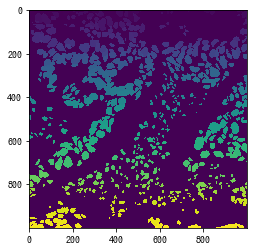

In [80]:
import scipy.io
a=scipy.io.loadmat('hovernet/u8_2.mat')
plt.imshow(a['inst_map'])
imsave('hovernet/test_11.png',a['inst_map'])